# <h1 style="color:#ff69b4">1-Import Libraries</h1>


In [56]:
# Basic libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import shap

# Machin Learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression



# Imbalance handling becuase of the target variable
from sklearn.utils.class_weight import compute_class_weight

# Warnings for try and except
import warnings
warnings.filterwarnings('ignore')

# <h1 style="color:#ff69b4">2-Read and understand the AML dataset</h1>


In [2]:
# Load dataset
file_path = "/Users/parisa/Desktop/DFS/SAML-D.csv" 
transaction_data = pd.read_csv(file_path)

In [3]:
# Preview of the dataset to understand the data
print("Dataset Shape:", transaction_data.shape)
print("Column names:", transaction_data.columns.tolist())
transaction_data.head()

Dataset Shape: (9504852, 12)
Column names: ['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Is_laundering', 'Laundering_type']


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [4]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    object 
 1   Date                    object 
 2   Sender_account          int64  
 3   Receiver_account        int64  
 4   Amount                  float64
 5   Payment_currency        object 
 6   Received_currency       object 
 7   Sender_bank_location    object 
 8   Receiver_bank_location  object 
 9   Payment_type            object 
 10  Is_laundering           int64  
 11  Laundering_type         object 
dtypes: float64(1), int64(3), object(8)
memory usage: 870.2+ MB


# <h1 style="color:#ff69b4">3-Exploratory Data Analysis (EDA)</h1>


In [5]:
# Drop duplicates and check for nulls rows
transaction_data.drop_duplicates(inplace=True)
print("Null values per column:")
print(transaction_data.isnull().sum())


Null values per column:
Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
dtype: int64


In [6]:
# check negative or zero amount
negative_amount = (transaction_data['Amount'] <= 0).sum()
print("negative or zero amount : \n", negative_amount)

negative or zero amount : 
 0


In [7]:
# count of is laundering
is_laundering_counts = transaction_data['Is_laundering'].value_counts()
print("count of is laundering : \n", is_laundering_counts)

count of is laundering : 
 Is_laundering
0    9494979
1       9873
Name: count, dtype: int64


In [8]:
# Cross-tab Payment Type vs. Is_laundering
if 'Payment_type' in transaction_data.columns and 'Is_laundering' in transaction_data.columns:
    cross_tab = pd.crosstab(transaction_data['Payment_type'], transaction_data['Is_laundering'])

    # Compute total laundering cases (sum of column 1.0)
    total_laundering_cases = cross_tab[1.0].sum()

    # Modify the table directly: Percentage of laundering cases within total laundering cases
    cross_tab[1.0] = cross_tab[1.0].astype(str) + " (" + (cross_tab[1.0].astype(int) / total_laundering_cases * 100).round(2).astype(str) + "%)"

    # Print and display results
    print("\nPayment Type vs. Laundering Cross-Tab (Percentage of Each Laundering Type from Total Laundering Cases):")
    display(cross_tab)


Payment Type vs. Laundering Cross-Tab (Percentage of Each Laundering Type from Total Laundering Cases):


Is_laundering,0,1
Payment_type,,
ACH,2007648,1159 (11.74%)
Cash Deposit,223801,1405 (14.23%)
Cash Withdrawal,299143,1334 (13.51%)
Cheque,2010332,1087 (11.01%)
Credit card,2011773,1136 (11.51%)
Cross-border,931303,2628 (26.62%)
Debit card,2010979,1124 (11.38%)


### Check to see the different types of transactions monitored in the dataset.

In [9]:
# Transactions count by payment type
payment_type_counts = transaction_data['Payment_type'].value_counts()
print("Transactions count by payment type : \n", payment_type_counts)

Transactions count by payment type : 
 Payment_type
Credit card        2012909
Debit card         2012103
Cheque             2011419
ACH                2008807
Cross-border        933931
Cash Withdrawal     300477
Cash Deposit        225206
Name: count, dtype: int64


In [10]:
# transaction count by laundering type
laundering_type_counts = transaction_data['Laundering_type'].value_counts()
print("transaction count by laundering type : \n", laundering_type_counts)

transaction count by laundering type : 
 Laundering_type
Normal_Small_Fan_Out      3477717
Normal_Fan_Out            2302220
Normal_Fan_In             2104285
Normal_Group               528351
Normal_Cash_Withdrawal     305031
Normal_Cash_Deposits       223801
Normal_Periodical          210526
Normal_Plus_Mutual         155041
Normal_Mutual              125335
Normal_Foward               42031
Normal_single_large         20641
Structuring                  1870
Cash_Withdrawal              1334
Deposit-Send                  945
Smurfing                      932
Layered_Fan_In                656
Layered_Fan_Out               529
Stacked Bipartite             506
Behavioural_Change_1          394
Bipartite                     383
Cycle                         382
Fan_In                        364
Gather-Scatter                354
Behavioural_Change_2          345
Scatter-Gather                338
Single_large                  250
Fan_Out                       237
Over-Invoicing           

### Dictionary for different types of laundering: 
1.	Normal_Small_Fan_Out: A single account disperses small amounts of funds to multiple accounts.
2.	Normal_Fan_Out: A single account disperses funds to multiple accounts.
3.	Normal_Fan_In: Multiple accounts transfer funds into a single account.
4.	Normal_Group: Transactions occurring within a specific group of accounts, possibly indicating internal transfers or routine business operations.
5.	Normal_Cash_Withdrawal: Standard cash withdrawals from an account.
6.	Normal_Cash_Deposits: Standard cash deposits into an account.
7.	Normal_Periodical: Regular, recurring transactions, such as monthly subscriptions or salary payments.
8.	Normal_Plus_Mutual: Transactions that involve mutual exchanges between accounts, possibly indicating reciprocal transactions.
9.	Normal_Mutual: Mutual transactions between two accounts, such as transfers back and forth.
10.	Normal_Foward: Transactions that are forwarded from one account to another, possibly as part of a chain of transactions.
11.	Normal_single_large: A single, large transaction that is considered normal for the account holder.
12.	Structuring: Also known as smurfing, this involves breaking down large sums of money into smaller, less conspicuous amounts to avoid triggering mandatory reporting requirements by financial institutions.
13.	Cash_Withdrawal: Large or frequent cash withdrawals that may raise suspicion, especially if inconsistent with the account holder's typical behavior.
14.	Deposit-Send: Depositing funds into an account and then quickly sending them to another account, which can be indicative of layering in money laundering.
15.	Smurfing: A form of structuring where large transactions are divided into smaller ones to evade detection.
16.	Layered_Fan_In: Multiple smaller transactions from different sources are combined into a single account, obscuring the original source of funds.
17.	Layered_Fan_Out: Funds from a single account are dispersed into multiple accounts to obscure the trail of money.
18.	Stacked Bipartite: Complex transactions involving two distinct sets of accounts, which can be used to obscure the flow of funds.
19.	Behavioural_Change_1: Notable changes in transaction behavior that may indicate suspicious activity.
20.	Bipartite: Transactions between two distinct groups of accounts, which can be analyzed for patterns indicative of money laundering.
21.	Cycle: Funds move in a circular pattern among accounts, which can be a tactic to disguise the origin of funds.
22.	Fan_In: Multiple accounts transfer funds into a single account, which can be used to aggregate illicit funds.
23.	Gather-Scatter: Funds are gathered into a single account and then dispersed to multiple accounts, complicating the tracking of money flow.
24.	Behavioural_Change_2: Another category indicating significant changes in transaction behavior that could signal suspicious activity.
25.	Scatter-Gather: Funds are dispersed from one account to many and then gathered back into a single account, a method that can obscure the money trail.
26.	Single_large: A single large transaction that deviates from the account's typical activity, potentially raising red flags.
27.	Fan_Out: A single account disperses funds to multiple accounts, which can be a method to launder money by spreading it across various accounts.
28.	Over-Invoicing: Inflating the value of goods or services on invoices to transfer additional value, a common trade-based money laundering technique.

In [11]:
# Count of transaction for sender bank location
sender_location_counts = transaction_data['Sender_bank_location'].value_counts()
print("count of transaction for sender bank location : \n", sender_location_counts)

count of transaction for sender bank location : 
 Sender_bank_location
UK             9183088
Turkey           20902
Switzerland      20503
Pakistan         20346
UAE              20081
Nigeria          20027
Spain            19391
Germany          19259
USA              19027
Italy            18895
France           18702
Japan            18468
Morocco          18437
Austria          18050
Mexico           17662
Albania          17648
India            17596
Netherlands      16770
Name: count, dtype: int64


In [12]:
# Count of transaction for reciever bank location
reciever_location_counts = transaction_data['Receiver_bank_location'].value_counts()
print("count of transaction for reciever bank location : \n", reciever_location_counts)

count of transaction for reciever bank location : 
 Receiver_bank_location
UK             8864634
Pakistan         38980
Austria          38844
Albania          38783
Japan            38729
Morocco          38704
Germany          38540
France           38512
Mexico           38385
Nigeria          38272
Netherlands      37314
Spain            37288
India            36936
USA              36850
Italy            36517
Switzerland      36081
UAE              35897
Turkey           35586
Name: count, dtype: int64


In [13]:
# Count of recieved currency
recieved_currency_counts = transaction_data['Received_currency'].value_counts()
print("Count of recieved currency : \n", recieved_currency_counts)

Count of recieved currency : 
 Received_currency
UK pounds          8783655
Euro                231911
Pakistani rupee      45993
Yen                  45814
Moroccan dirham      45748
Albanian lek         45736
Mexican Peso         45255
Naira                45046
Indian rupee         43757
US dollar            43664
Swiss franc          42931
Dirham               42797
Turkish lira         42545
Name: count, dtype: int64


In [14]:
# Create dataframe for laundering transactions
laundering_transactions = transaction_data[transaction_data['Is_laundering'] == 1]

# Display the first few rows of the dataframe
laundering_transactions.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
317,10:46:37,2022-10-07,7401327478,4336451277,2603.30,UK pounds,UK pounds,UK,UK,Cash Deposit,1,Smurfing
1206,11:19:32,2022-10-07,6340007440,4316483340,106.04,UK pounds,Indian rupee,UK,India,Cash Withdrawal,1,Cash_Withdrawal
1649,11:35:42,2022-10-07,3758118046,6081504025,5903.33,UK pounds,Mexican Peso,UK,Mexico,Cross-border,1,Behavioural_Change_2
1954,11:45:53,2022-10-07,445154846,4497771501,3957.87,UK pounds,Naira,UK,Nigeria,Cross-border,1,Structuring
3304,12:39:03,2022-10-07,2758469152,2987279234,7832.41,UK pounds,UK pounds,UK,UK,Debit card,1,Structuring


# <h1 style="color:#ff69b4">4-Visualization</h1>

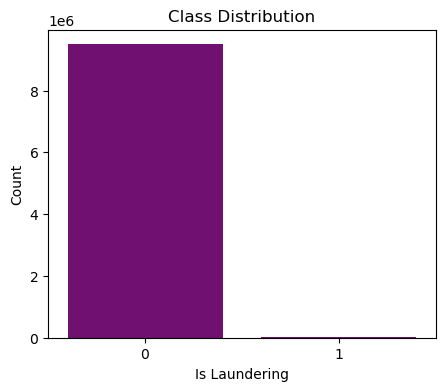

In [15]:
# Get the current class distribution
plt.figure(figsize=(5,4))
sns.countplot(data=transaction_data, x='Is_laundering')
plt.title("Class Distribution")
plt.xlabel("Is Laundering")
plt.ylabel("Count")
sns.countplot(data=transaction_data, x='Is_laundering', color="#800080")
plt.show()

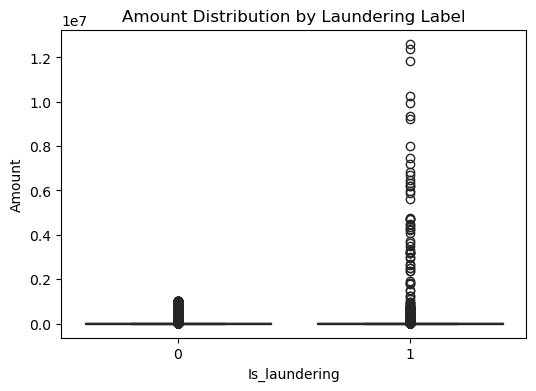

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [16]:
# Amount distribution
plt.figure(figsize=(6,4))
sns.boxplot(data=transaction_data, x='Is_laundering', y='Amount',color="#800080")
plt.title("Amount Distribution by Laundering Label")
plt.show()
plt.figure(figsize=(6,4))

## <h2 style="color:#00ced1">Conclusion:</h3>

### Almost all transactions (99.9%) are not laundering, and only 0.1% are marked as laundering, showing a strong class imbalance in the data.

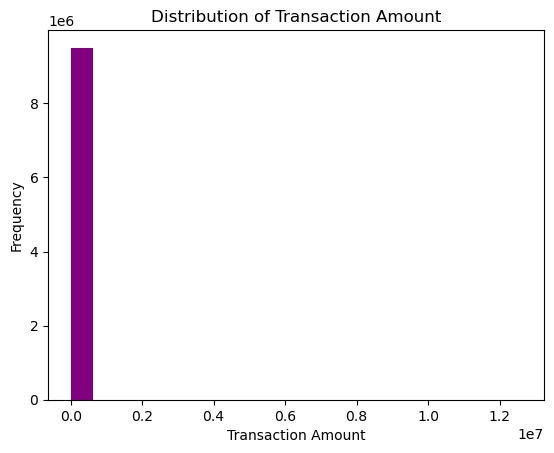

In [17]:
# Visualize distribution of transaction amount
plt.hist(transaction_data['Amount'], bins=20, color="#800080")
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Amount')
plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>

### Most transactions have very small amounts, while a few transactions have extremely high values, causing an uneven distribution.

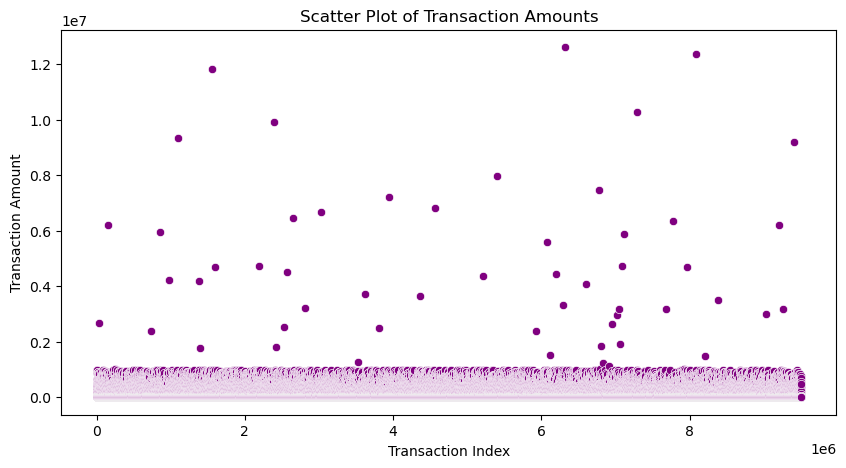

In [18]:
# Visualize distribution of transaction amount
plt.figure(figsize=(10, 5))
sns.scatterplot(x=transaction_data.index, y= transaction_data ['Amount'], color="#800080")
plt.title("Scatter Plot of Transaction Amounts")
plt.xlabel("Transaction Index")
plt.ylabel("Transaction Amount")
plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### Most transactions have small amounts, but there are some high-value transactions scattered throughout, indicating potential outliers.

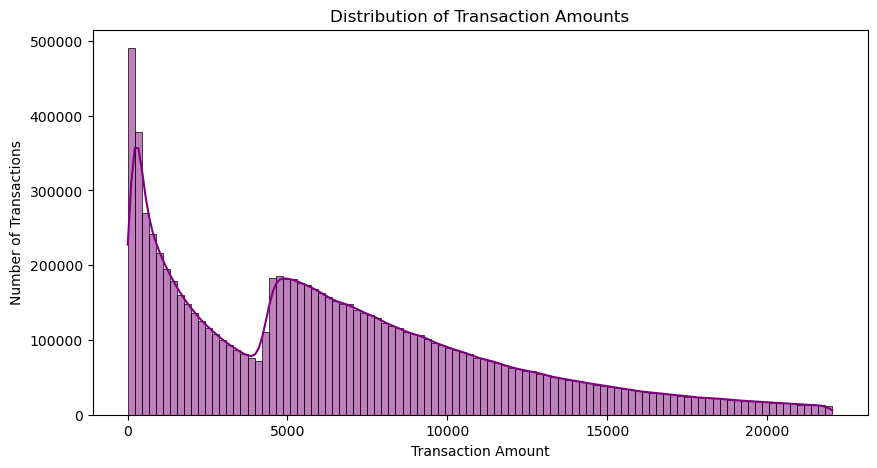

In [19]:
# Visualize distribution of transaction amount
plt.figure(figsize=(10, 5))

# Define a threshold to exclude extreme outliers wich we choose 95% of the data
x_max = transaction_data['Amount'].quantile(0.95)

# Filter dataset to exclude transactions above x_max
filtered_data = transaction_data[transaction_data['Amount'] <= x_max]
sns.histplot(filtered_data['Amount'], bins=100, kde=True, color="#800080")
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Number of Transactions")

plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### Without extreme outliers, the majority of transactions are small amounts, with a gradual decrease as amounts increase, but there are still some peaks at mid-range values

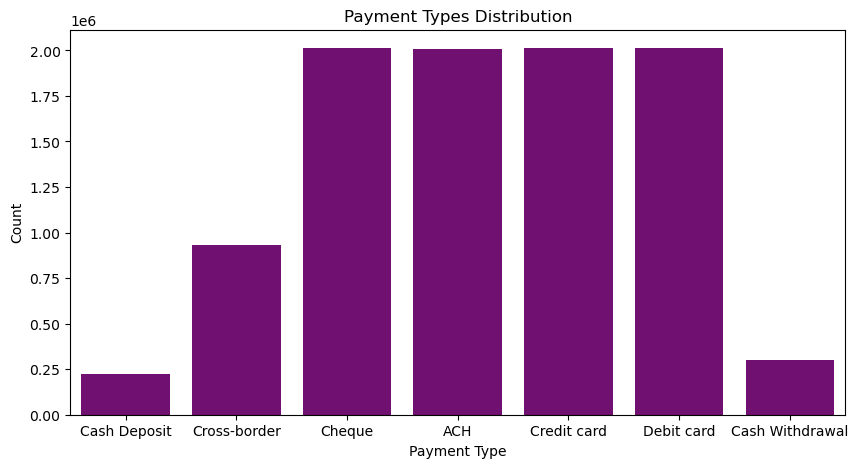

In [20]:
# Payement types distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='Payment_type', data=transaction_data, color="#800080")
plt.title("Payment Types Distribution")
plt.xlabel("Payment Type")
plt.ylabel("Count")
plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### Most transactions use Cheque, ACH, Credit card, and Debit card, while Cash Deposits and Cash Withdrawals are much less common.

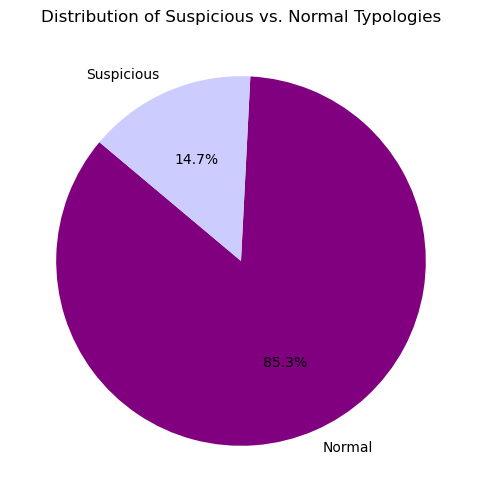

In [21]:
# Laundering types distribution
normal_typologies = ['Normal_Cash_Deposits', 'Normal_Fan_Out', 'Normal_Small_Fan_Out', 'Normal_Fan_In']
transaction_data['Typology_Category'] = transaction_data['Laundering_type'].apply(lambda x: 'Suspicious' if x not in normal_typologies else 'Normal')
# Plot the distribution of typologies
typology_category_counts = transaction_data['Typology_Category'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(typology_category_counts, labels=typology_category_counts.index, autopct='%1.1f%%', colors=['purple', '#CCCCFF'], startangle=140)
plt.title("Distribution of Suspicious vs. Normal Typologies")
plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### Most transactions are normal (85.3%), while a smaller portion (14.7%) is classified as suspicious, which may indicate potential money laundering activity.

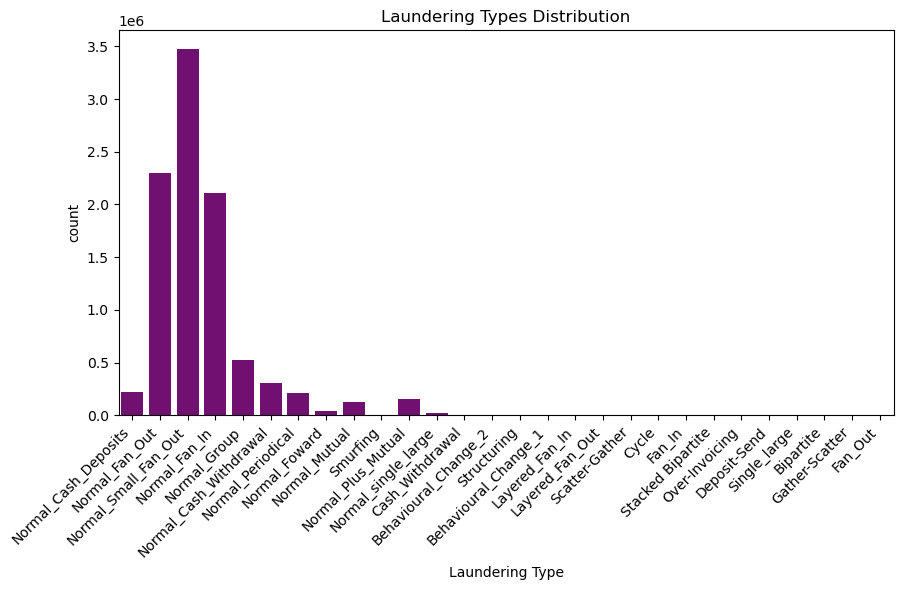

In [22]:
# Distribution of laundering type
plt.figure(figsize=(10, 5))
sns.countplot(x='Laundering_type', data=transaction_data, color="#800080")
plt.title("Laundering Types Distribution")
plt.xlabel("Laundering Type")
plt.xticks(rotation=45, ha='right')
plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### A few laundering types, such as Normal Fan Out and Normal Small Fan Out, occur most frequently, while others are rare, suggesting that certain transaction patterns dominate the dataset.

In [23]:
# Distribution of sender bank location
sender_col = "Sender_bank_location"  
laundering_type_col = "Laundering_type"  
laundering_flag_col = "Is_laundering"

# Convert laundering flag to integer
transaction_data[laundering_flag_col] = transaction_data[laundering_flag_col].astype(int)

# Filter only laundering transactions
laundering_transaction_data = transaction_data[transaction_data[laundering_flag_col] == 1]

# Group by sender location and laundering type
laundering_counts = laundering_transaction_data.groupby([sender_col, laundering_type_col]).size().reset_index(name="Count")
total_transactions = transaction_data.groupby(sender_col).size().reset_index(name="Total_Transactions")

# Merge with total transactions
laundering_percentage = laundering_counts.merge(total_transactions, on=sender_col)
laundering_percentage["Laundering_Percentage"] = (laundering_percentage["Count"] / laundering_percentage["Total_Transactions"])*100

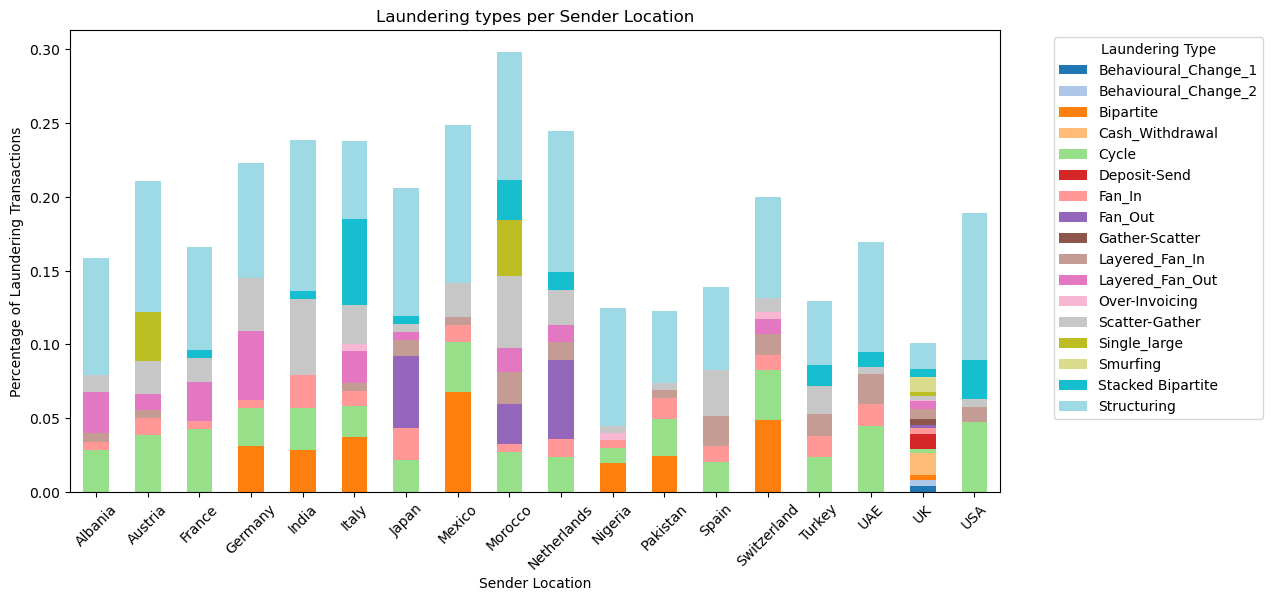

In [24]:
# Pivot the data for plotting
pivot_data = laundering_percentage.pivot(index=sender_col, columns=laundering_type_col, values="Laundering_Percentage")

# Define a custom purple colormap
purple_cmap = cm.get_cmap("tab20", pivot_data.shape[1])

# Plot the stacked bar chart with purple shades
pivot_data.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    colormap=purple_cmap
)

plt.xlabel("Sender Location")
plt.ylabel("Percentage of Laundering Transactions")
plt.title("Laundering types per Sender Location")
plt.xticks(rotation=45)
plt.legend(title="Laundering Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


## <h2 style="color:#00ced1">Conclusion:</h3>
### Some countries like Morocco, Mexico, and the Netherlands show a higher percentage of laundering transactions, and the types of laundering vary by location, which could help in identifying country-specific patterns.

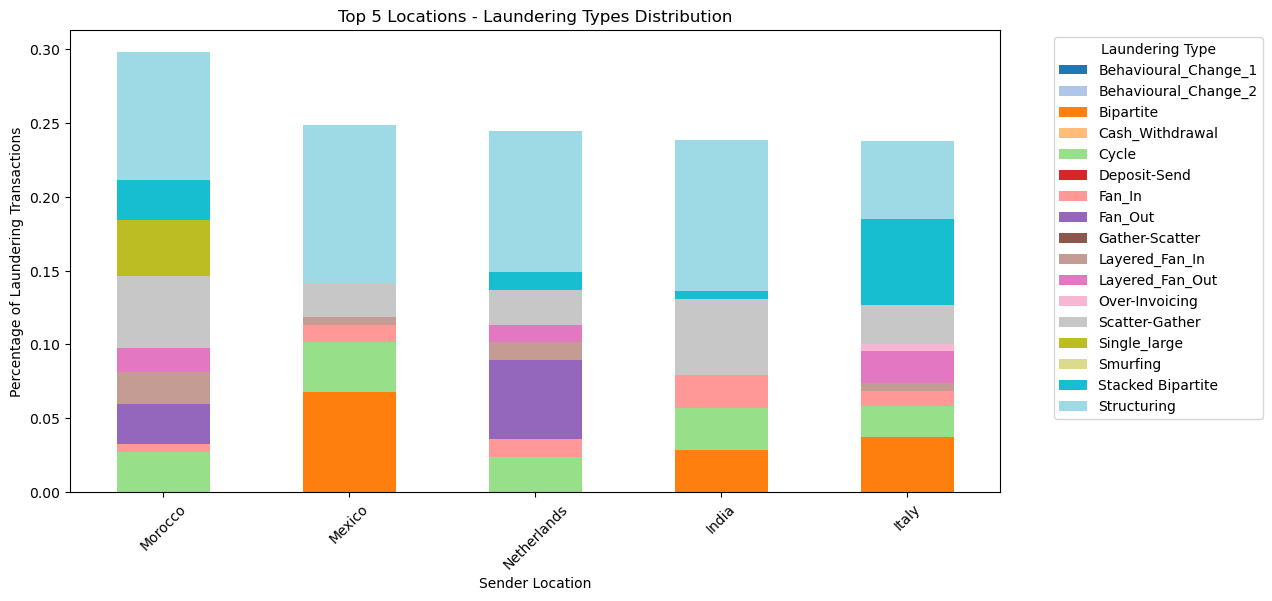

In [25]:
# Get top 5 locations by total laundering percentage
top_locations = pivot_data.sum(axis=1).nlargest(5).index
pivot_top = pivot_data.loc[top_locations]

purple_cmap = cm.get_cmap("tab20", pivot_top.shape[1])

# Plot the stacked bar chart for top 5 locations
pivot_top.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    colormap=purple_cmap
)

plt.xlabel("Sender Location")
plt.ylabel("Percentage of Laundering Transactions")
plt.title("Top 5 Locations - Laundering Types Distribution")
plt.xticks(rotation=45)
plt.legend(title="Laundering Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### The top 5 countries with the highest laundering activity are Morocco, Mexico, Netherlands, India, and Italy, each showing different mixes of laundering types, with Structuring being the most dominant across all.

In [26]:
# Distribution of reciever bank location
sender_col = "Receiver_bank_location"  
laundering_type_col = "Laundering_type"  
laundering_flag_col = "Is_laundering"

transaction_data[laundering_flag_col] = transaction_data[laundering_flag_col].astype(int)

laundering_transaction_data = transaction_data[transaction_data[laundering_flag_col] == 1]

# Group by sender location and laundering type
laundering_counts = laundering_transaction_data.groupby([sender_col, laundering_type_col]).size().reset_index(name="Count")

# Total transactions per sender location
total_transactions = transaction_data.groupby(sender_col).size().reset_index(name="Total_Transactions")

# Merge with total transactions
laundering_percentage = laundering_counts.merge(total_transactions, on=sender_col)
laundering_percentage["Laundering_Percentage"] = (laundering_percentage["Count"] / laundering_percentage["Total_Transactions"])*100

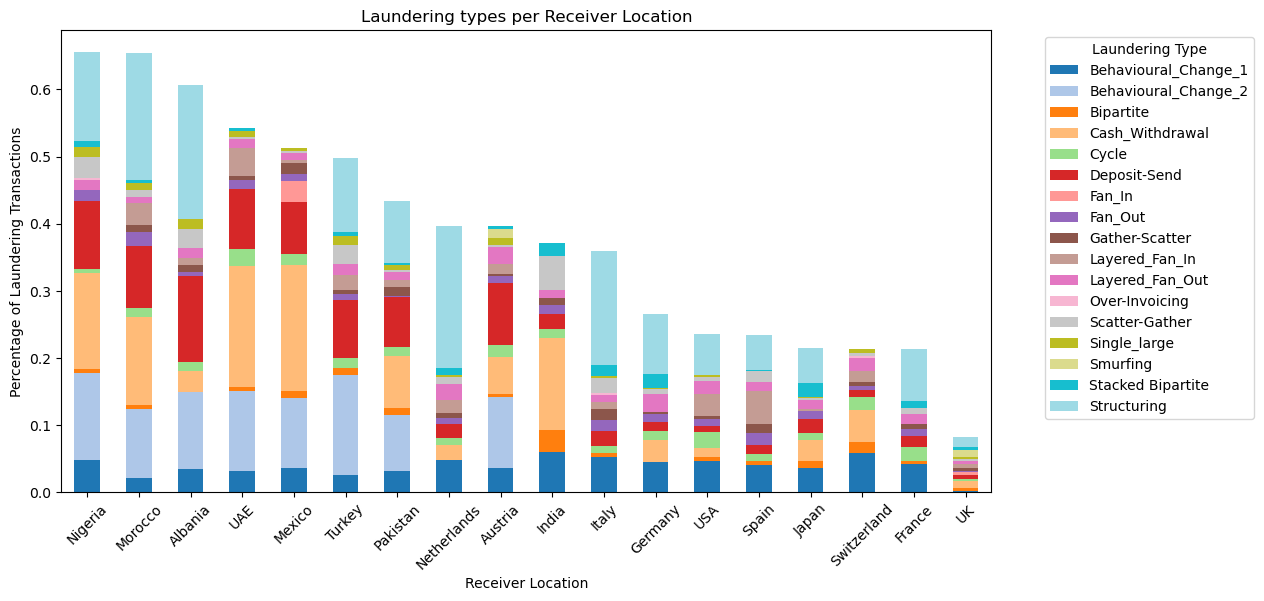

In [27]:
# Pivot the data for plotting
pivot_data = laundering_percentage.pivot(index=sender_col, columns=laundering_type_col, values="Laundering_Percentage")

# Sort locations by total laundering percentage
pivot_data["Total"] = pivot_data.sum(axis=1)
pivot_data = pivot_data.sort_values(by="Total", ascending=False).drop(columns=["Total"])

purple_cmap = cm.get_cmap("tab20", pivot_data.shape[1])

# Plot the stacked bar chart
pivot_data.plot(kind="bar", stacked=True, figsize=(12, 6), colormap=purple_cmap)

plt.xlabel("Receiver Location")
plt.ylabel("Percentage of Laundering Transactions")
plt.title("Laundering types per Receiver Location")
plt.xticks(rotation=45)
plt.legend(title="Laundering Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### This chart shows that countries like Nigeria, Morocco, and Albania receive a higher percentage of laundering transactions, with Structuring, Cash Withdrawal, and Deposit-Send among the most common types received.

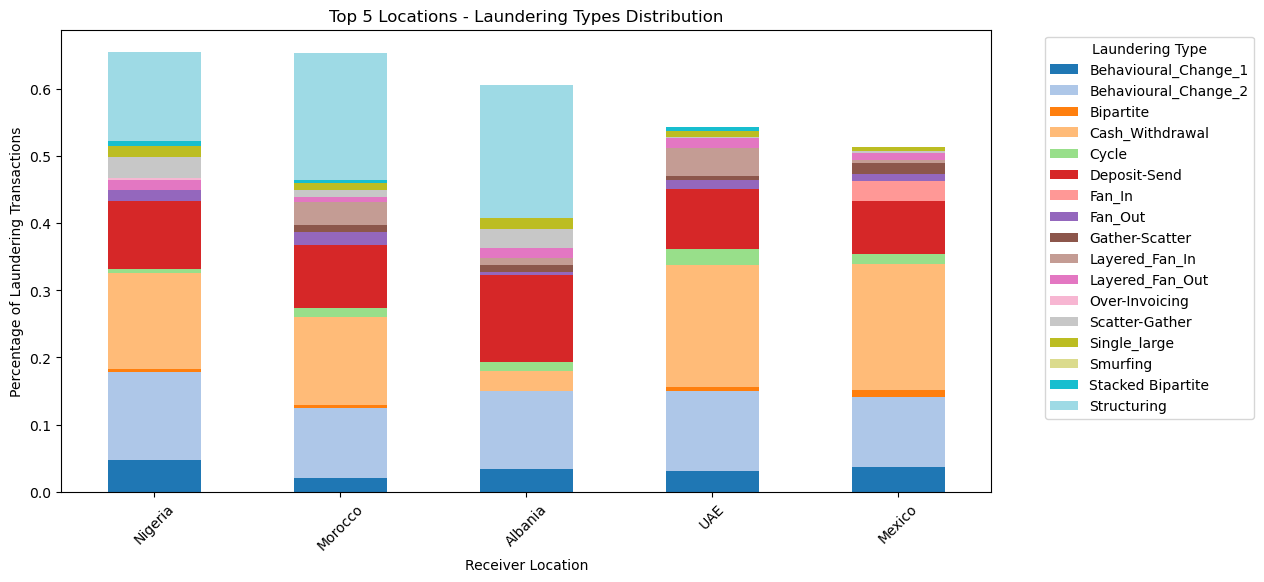

In [28]:
top_locations = pivot_data.sum(axis=1).nlargest(5).index
pivot_top = pivot_data.loc[top_locations]
purple_cmap = cm.get_cmap("tab20", pivot_data.shape[1])

# Plot the stacked bar chart for top 5 locations
pivot_top.plot(kind="bar", stacked=True, figsize=(12, 6), colormap=purple_cmap)

plt.xlabel("Receiver Location")
plt.ylabel("Percentage of Laundering Transactions")
plt.title("Top 5 Locations - Laundering Types Distribution")
plt.xticks(rotation=45)
plt.legend(title="Laundering Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### This chart highlights that Nigeria, Morocco, and Albania have the highest share of laundering transactions received, with Structuring, Cash Withdrawal, and Fan_In being some of the most dominant laundering types in these countries.

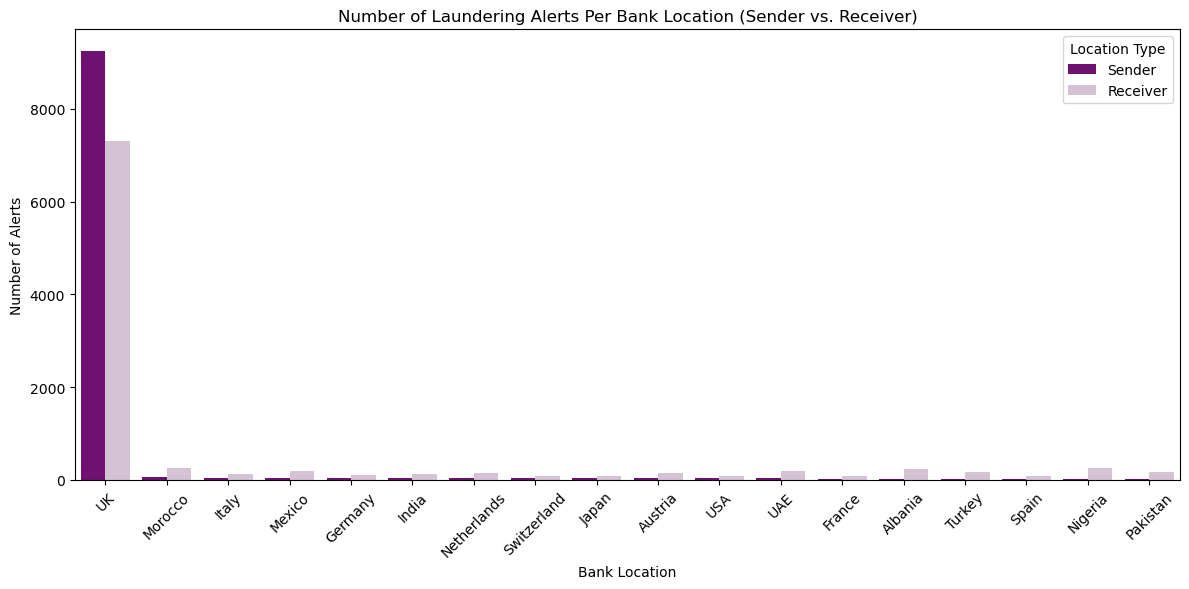

In [29]:
# Count alerts per sender bank location
sender_alerts = laundering_transactions['Sender_bank_location'].value_counts().reset_index()
sender_alerts.columns = ['Bank Location', 'Alert_Count']
sender_alerts['Type'] = 'Sender'

# Count alerts per receiver bank location
receiver_alerts = laundering_transactions['Receiver_bank_location'].value_counts().reset_index()
receiver_alerts.columns = ['Bank Location', 'Alert_Count']
receiver_alerts['Type'] = 'Receiver'

# Combine sender and receiver alerts into one DataFrame
alerts_per_location = pd.concat([sender_alerts, receiver_alerts])

# Plot the number of alerts per bank location
plt.figure(figsize=(12, 6))
sns.barplot(data=alerts_per_location, x='Bank Location', y='Alert_Count', hue='Type', palette=['#800080', '#D8BFD8'])

plt.title("Number of Laundering Alerts Per Bank Location (Sender vs. Receiver)")
plt.xlabel("Bank Location")
plt.ylabel("Number of Alerts")
plt.xticks(rotation=45)
plt.legend(title="Location Type")
plt.tight_layout()
plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### The chart shows that the UK has the highest number of money laundering alerts, especially from sender banks. Other countries have much fewer alerts in comparison.

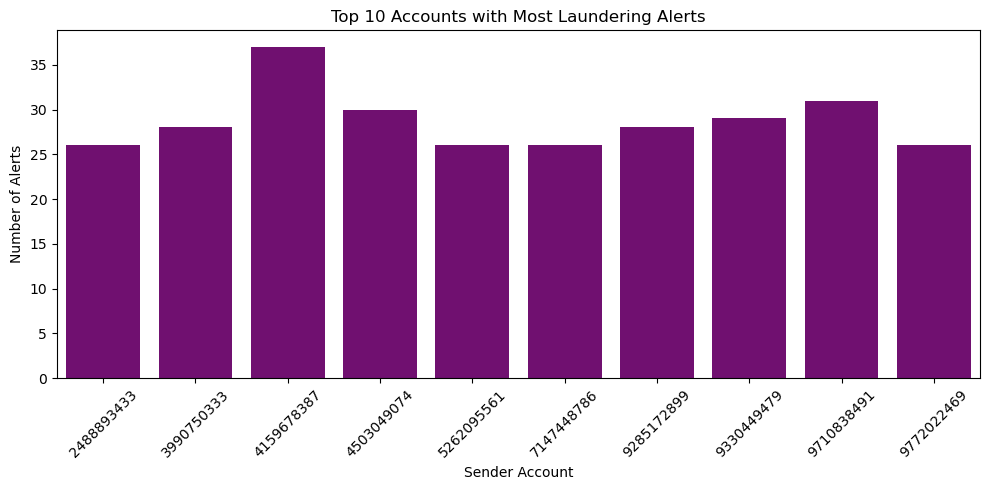

In [30]:
# Count alerts per sender account
account_alert_counts = laundering_transactions['Sender_account'].value_counts().reset_index()
account_alert_counts.columns = ['Sender_account', 'Alert_Count']

# Get the top 10 alerted accounts
top_alerted_accounts = account_alert_counts.head(10)

# Plot the top 10 accounts with most alerts
plt.figure(figsize=(10, 5))
sns.barplot(data=top_alerted_accounts, x='Sender_account', y='Alert_Count', color='#800080')

# Add labels and title
plt.title("Top 10 Accounts with Most Laundering Alerts")
plt.xlabel("Sender Account")
plt.ylabel("Number of Alerts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### This bar chart shows the top 10 sender accounts with the highest number of laundering alerts. One account (ending in 7837) has the most alerts, while others have slightly fewer, but still show suspicious activity.

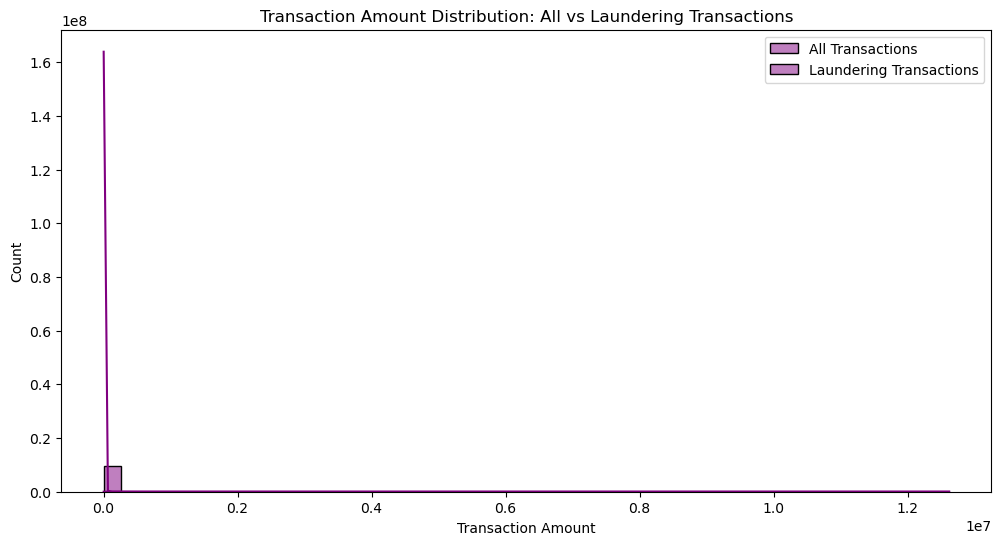

In [31]:
# Count alerts per receiver account
plt.figure(figsize=(12, 6))

# Plot histogram for all the transactions
sns.histplot(transaction_data['Amount'], bins=50, kde=True, color="purple", label="All Transactions", alpha=0.5)

# Plot histogram for Only laundering transactions
sns.histplot(laundering_transactions['Amount'], bins=50, kde=True, color= '#800080' , label="Laundering Transactions", alpha=0.5)

plt.title("Transaction Amount Distribution: All vs Laundering Transactions")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.legend()
plt.show()


## <h2 style="color:#00ced1">Conclusion:</h3>
### This chart compares the transaction amounts for all transactions versus laundering transactions. Most values are low for both, but laundering transactions show a few higher amounts, suggesting possible outliers or large suspicious activities.

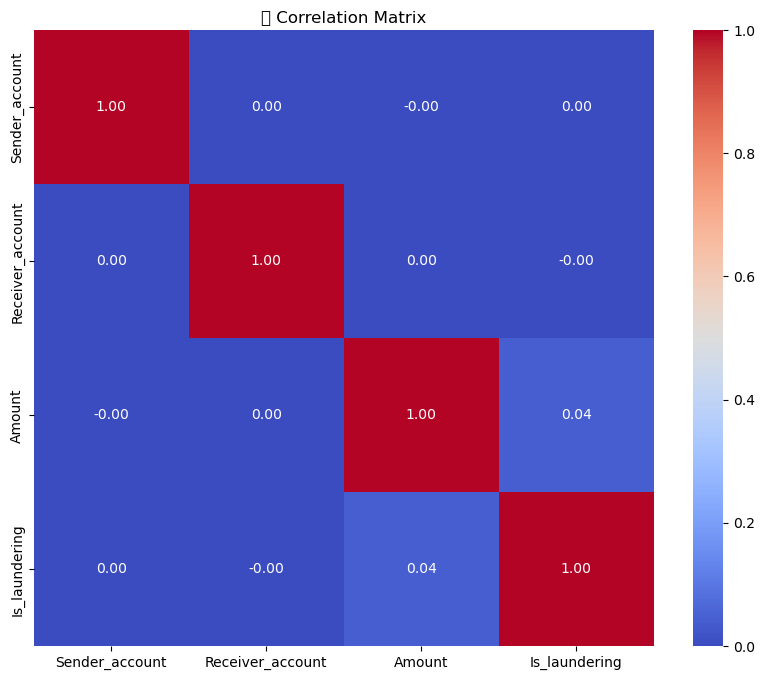

In [32]:
# Select only numeric columns
numeric_df = transaction_data.select_dtypes(include=['int64', 'int32', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔍 Correlation Matrix")
plt.show()


## <h2 style="color:#00ced1">Conclusion:</h3>
### All correlations with the target are close to zero, including “Amount” which has the highest at only 0.04. This weak linear correlation indicates that individual features are not strongly predictive on their own.

# <h1 style="color:#ff69b4">5-Feature Engineering</h1>

In [33]:
# Combine and parse datetime
transaction_data['Datetime'] = pd.to_datetime(transaction_data['Date'] + ' ' + transaction_data['Time'], errors='coerce')
transaction_data.drop(['Date', 'Time'], axis=1, inplace=True)

In [34]:
# Extract features from datetime
transaction_data['Hour'] = transaction_data['Datetime'].dt.hour
transaction_data['DayOfWeek'] = transaction_data['Datetime'].dt.dayofweek
transaction_data['Month'] = transaction_data['Datetime'].dt.month
transaction_data['Year'] = transaction_data['Datetime'].dt.year


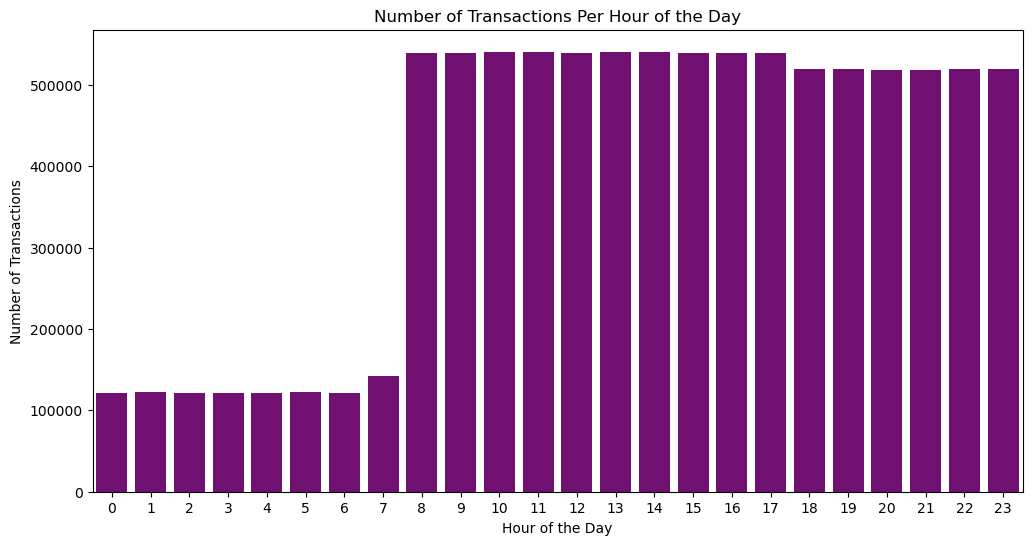

In [35]:
# Count total transactions per hour of the day
transactions_per_hour = transaction_data['Hour'].value_counts().sort_index()

# Plot total transactions per hour of the day
plt.figure(figsize=(12, 6))
sns.barplot(x=transactions_per_hour.index, y=transactions_per_hour.values, color= '#800080')
plt.title("Number of Transactions Per Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### This chart shows that most transactions happen during working hours (8 AM to 5 PM), while very few occur during the night and early morning hours (midnight to 7 AM).

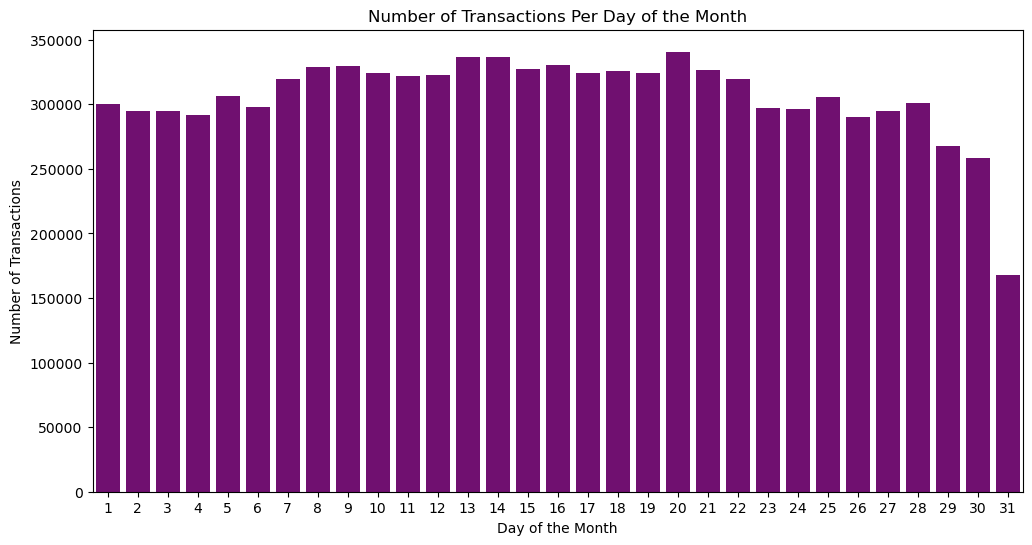

In [36]:
# Extract day of the month
transaction_data['Day'] = transaction_data['Datetime'].dt.day

# Count transactions per day
transactions_per_day = transaction_data['Day'].value_counts().sort_index()

# Plot the number of transactions per day
plt.figure(figsize=(12, 6))
sns.barplot(x=transactions_per_day.index, y=transactions_per_day.values, color= '#800080')

# Add labels and title
plt.title("Number of Transactions Per Day of the Month")
plt.xlabel("Day of the Month")
plt.ylabel("Number of Transactions")

plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### This chart shows that transactions are more frequent in the middle of the month, especially around days 13 to 20, while the number drops noticeably towards the end of the month, especially after day 27.

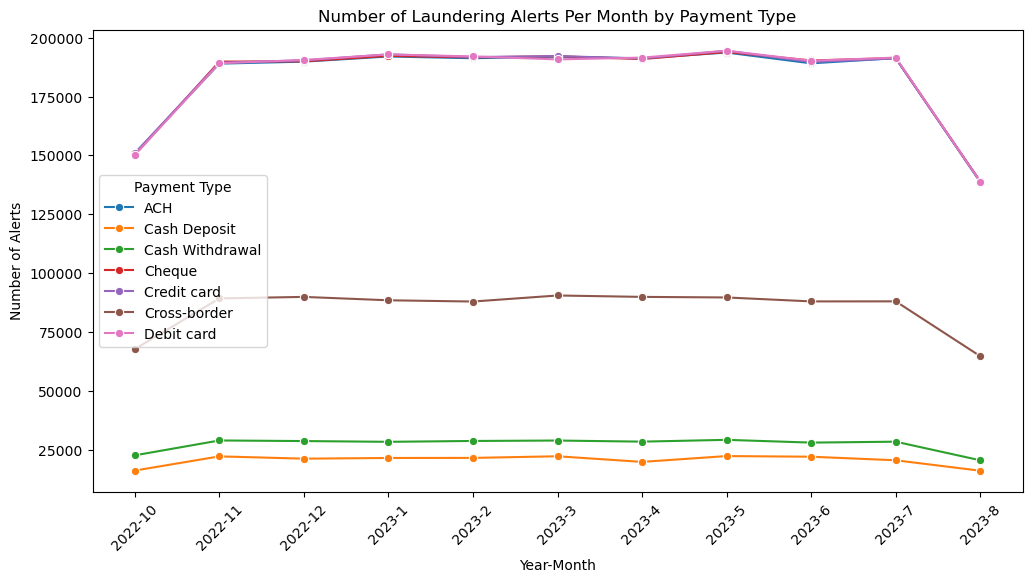

In [37]:
# Count alerts per month split by payment type
alerts_per_month = transaction_data.groupby(['Year', 'Month', 'Payment_type']).size().reset_index(name='Alert_Count')

# Create a combined "Year-Month" column for better visualization
alerts_per_month['Year-Month'] = alerts_per_month['Year'].astype(str) + '-' + alerts_per_month['Month'].astype(str)

# Plot the number of alerts per month, split by payment type
plt.figure(figsize=(12, 6))
sns.lineplot(data=alerts_per_month, x='Year-Month', y='Alert_Count', hue='Payment_type', marker='o')

# Improve readability
plt.xticks(rotation=45)
plt.title("Number of Laundering Alerts Per Month by Payment Type")
plt.xlabel("Year-Month")
plt.ylabel("Number of Alerts")
plt.legend(title="Payment Type")
plt.show()

## <h2 style="color:#00ced1">Conclusion:</h3>
### This chart shows that debit card transactions have the highest number of laundering alerts each month, followed by credit cards. Other payment types like cash deposits and ACH have fewer alerts. The trend is quite stable over time.

In [38]:
# Create a new column to check if the sender and receiver are from different countries
transaction_data['Different_Country'] = (transaction_data['Sender_bank_location'] != transaction_data['Receiver_bank_location']).astype(int)

# Display the updated dataframe
transaction_data.head()

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type,Typology_Category,Datetime,Hour,DayOfWeek,Month,Year,Day,Different_Country
0,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,Normal,2022-10-07 10:35:19,10,4,10,2022,7,0
1,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out,Normal,2022-10-07 10:35:20,10,4,10,2022,7,1
2,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out,Normal,2022-10-07 10:35:20,10,4,10,2022,7,0
3,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,Normal,2022-10-07 10:35:21,10,4,10,2022,7,0
4,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,Normal,2022-10-07 10:35:21,10,4,10,2022,7,0


In [39]:
# Create a new column to check if the payment and received currency are different
transaction_data['Different_Currency'] = (transaction_data['Payment_currency'] != transaction_data['Received_currency']).astype(int)

# Display the updated dataframe
transaction_data.head()

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type,Typology_Category,Datetime,Hour,DayOfWeek,Month,Year,Day,Different_Country,Different_Currency
0,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,Normal,2022-10-07 10:35:19,10,4,10,2022,7,0,0
1,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out,Normal,2022-10-07 10:35:20,10,4,10,2022,7,1,1
2,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out,Normal,2022-10-07 10:35:20,10,4,10,2022,7,0,0
3,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,Normal,2022-10-07 10:35:21,10,4,10,2022,7,0,0
4,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,Normal,2022-10-07 10:35:21,10,4,10,2022,7,0,0


In [40]:
# Encode Hour column
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

transaction_data['Time_of_day'] = transaction_data['Hour'].apply(get_time_of_day)



In [41]:
# Encode Day column
def get_part_of_month(day):
    if day <= 10:
        return 'Beginning'
    elif day <= 20:
        return 'Middle'
    else:
        return 'End'

transaction_data['Part_of_month'] = transaction_data['Datetime'].dt.day.apply(get_part_of_month)

In [42]:
transaction_data

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type,...,Datetime,Hour,DayOfWeek,Month,Year,Day,Different_Country,Different_Currency,Time_of_day,Part_of_month
0,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,...,2022-10-07 10:35:19,10,4,10,2022,7,0,0,Morning,Beginning
1,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out,...,2022-10-07 10:35:20,10,4,10,2022,7,1,1,Morning,Beginning
2,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out,...,2022-10-07 10:35:20,10,4,10,2022,7,0,0,Morning,Beginning
3,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,...,2022-10-07 10:35:21,10,4,10,2022,7,0,0,Morning,Beginning
4,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,...,2022-10-07 10:35:21,10,4,10,2022,7,0,0,Morning,Beginning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9504847,2453933570,519744068,2247.25,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out,...,2023-08-23 10:57:01,10,2,8,2023,23,0,0,Morning,End
9504848,9805510177,5416607878,927.18,UK pounds,UK pounds,UK,UK,Debit card,0,Normal_Small_Fan_Out,...,2023-08-23 10:57:06,10,2,8,2023,23,0,0,Morning,End
9504849,7282330957,2995527149,1455.14,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Small_Fan_Out,...,2023-08-23 10:57:06,10,2,8,2023,23,0,0,Morning,End
9504850,940337377,4812815165,25995.70,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,...,2023-08-23 10:57:11,10,2,8,2023,23,0,0,Morning,End


# <h1 style="color:#ff69b4">6-Labeling the categorical columns</h1>

In [43]:
# List of categorical columns
cat_cols = [
    'Payment_currency',
    'Received_currency',
    'Sender_bank_location',
    'Receiver_bank_location',
    'Payment_type',
    'Time_of_day',
    'Part_of_month'
]

# Encode each column
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    transaction_data[col] = le.fit_transform(transaction_data[col])
    label_encoders[col] = le

print("✅ Encoding complete.")
print(transaction_data[cat_cols].head())

✅ Encoding complete.
   Payment_currency  Received_currency  Sender_bank_location  \
0                10                 10                    16   
1                10                  1                    16   
2                10                 10                    16   
3                10                 10                    16   
4                10                 10                    16   

   Receiver_bank_location  Payment_type  Time_of_day  Part_of_month  
0                      16             1            2              0  
1                      15             5            2              0  
2                      16             3            2              0  
3                      16             0            2              0  
4                      16             1            2              0  


# <h1 style="color:#ff69b4">7-Splitting Data for Training and Testing</h1>


In [44]:
# Separate features and target
X = transaction_data.drop(columns=[
    'Is_laundering',        
    'Datetime',             
    'Typology_Category',     
    'Sender_account',      
    'Receiver_account',      
    'Laundering_type'        
])

y = transaction_data['Is_laundering']

# Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=42, stratify=y_train_val
)

# Print sizes
print("✅ Split complete:")
print("Train shape:      ", X_train.shape)
print("Validation shape: ", X_val.shape)
print("Test shape:       ", X_test.shape)

✅ Split complete:
Train shape:       (5322716, 15)
Validation shape:  (2281165, 15)
Test shape:        (1900971, 15)


# <h1 style="color:#ff69b4">8-Rebalancing the training set with Class Weights</h1>


In [45]:
# Initialize the model
classes = np.unique(y_train)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

print("Computed class weights:")
print(class_weights_dict)

Computed class weights:
{0: 0.5005199177685494, 1: 481.34527039247604}


## <h2 style="color:#00ced1">Conclusion:</h3>
### Since the dataset is highly imbalanced — with a very small number of money laundering cases compared to normal transactions — we applied class weighting to help the model focus more on the minority class (Is_laundering = 1).
### we computed balanced class weights based only on the training set to avoid data leakage. These weights are used in our models to penalize misclassification of rare laundering cases more heavily.
- The weight for class 0 (normal) is ~0.50
- The weight for class 1 (laundering) is ~481.35
- This helps the model better detect laundering cases despite the class imbalance.

# <h1 style="color:#ff69b4">9-Train the models </h1>


## <h2 style="color:#00ced1">Logistic Regression:</h3>

In [59]:
# Initialize and train the model
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = lr_model.predict(X_val)
y_val_prob = lr_model.predict_proba(X_val)[:, 1]

# Evaluate performance
print("Logistic Regression - Validation Metrics:")
print(classification_report(y_val, y_val_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_prob))


Logistic Regression - Validation Metrics:
              precision    recall  f1-score   support

           0       1.00      0.75      0.85   2278796
           1       0.00      0.54      0.00      2369

    accuracy                           0.75   2281165
   macro avg       0.50      0.64      0.43   2281165
weighted avg       1.00      0.75      0.85   2281165

ROC AUC Score: 0.6888256244393545


## <h2 style="color:#00ced1">Conclusion:</h3>
### To establish a baseline, we implemented a Logistic Regression model using class weights to address the dataset's severe imbalance. Despite its simplicity, the model reached a ROC AUC score of 0.689, indicating moderate ability to differentiate between suspicious and normal transactions.
### However, while the model achieved 75% recall on the majority class (non-suspicious), its performance on the minority class was limited—recall for suspicious transactions was 54%, with precision dropping to 0%, suggesting many false positives. This outcome underscores the limitations of linear models when faced with highly skewed and complex financial transaction data.

## <h2 style="color:#00ced1">Random Forest</h3>


In [46]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,                 
    class_weight=class_weights_dict, 
    random_state=42,                 
    n_jobs=-1                       
)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred_rf = rf_model.predict(X_val)                        
y_val_proba_rf = rf_model.predict_proba(X_val)[:, 1]          

# Evaluate the model
print("Random Forest - Validation Metrics:")
print(confusion_matrix(y_val, y_val_pred_rf))                 
print(classification_report(y_val, y_val_pred_rf))           
print("AUC-ROC Score:", roc_auc_score(y_val, y_val_proba_rf))

Random Forest - Validation Metrics:
[[2278671     125]
 [   2242     127]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2278796
           1       0.50      0.05      0.10      2369

    accuracy                           1.00   2281165
   macro avg       0.75      0.53      0.55   2281165
weighted avg       1.00      1.00      1.00   2281165

AUC-ROC Score: 0.6028168988641712


## <h2 style="color:#00ced1">Confusion Matrix:</h3>

- True Negatives (TN): 2,278,671
- False Positives (FP): 125
- False Negatives (FN): 2,242
- True Positives (TP): 1,271

The Random Forest model performed extremely well at identifying normal transactions — it almost never made a mistake there. That’s not surprising, because the dataset is heavily imbalanced and most transactions are normal.
However, when it comes to detecting money laundering, which is the minority class, the model struggled. It only managed to correctly catch about 5% of actual laundering cases (recall = 0.05). That means most laundering transactions were missed.
On the positive side, when the model did predict a transaction as laundering, it was correct 50% of the time — so its precision is decent. This shows that the class weighting helped a bit, but it’s still not enough on its own.
The AUC-ROC score is around 0.60, which indicates the model has some ability to separate laundering from normal transactions — but it’s still far from ideal. We'll need to improve this by either adjusting the threshold, using a more powerful model like XGBoost, or even combining several techniques.

## <h2 style="color:#00ced1">XGBoost:</h3>

In [47]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=559.875,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Evaluate
y_val_pred_xgb = xgb_model.predict(X_val)
y_val_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
for threshold in [0.4, 0.3, 0.25, 0.2]:
    y_val_pred = (y_val_proba_xgb >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(confusion_matrix(y_val, y_val_pred))
    print(classification_report(y_val, y_val_pred))



Threshold: 0.4
[[1947127  331669]
 [    829    1540]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92   2278796
           1       0.00      0.65      0.01      2369

    accuracy                           0.85   2281165
   macro avg       0.50      0.75      0.47   2281165
weighted avg       1.00      0.85      0.92   2281165


Threshold: 0.3
[[1741833  536963]
 [    635    1734]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.87   2278796
           1       0.00      0.73      0.01      2369

    accuracy                           0.76   2281165
   macro avg       0.50      0.75      0.44   2281165
weighted avg       1.00      0.76      0.87   2281165


Threshold: 0.25
[[1454200  824596]
 [    449    1920]]
              precision    recall  f1-score   support

           0       1.00      0.64      0.78   2278796
           1       0.00      0.81      0.00      2369

    accuracy    

In [60]:
# Predict probabilities on validation set
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]

# Apply optimal threshold
optimal_threshold = 0.3
y_val_pred_opt = (y_val_proba >= optimal_threshold).astype(int)

# Evaluate performance
print(f"Threshold: {optimal_threshold}")
print("XGBoost - Validation Metrics:")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_opt))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_opt))
print("ROC AUC Score:", roc_auc_score(y_val, y_val_proba))


Threshold: 0.3
XGBoost - Validation Metrics:
Confusion Matrix:
 [[1741833  536963]
 [    635    1734]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.76      0.87   2278796
           1       0.00      0.73      0.01      2369

    accuracy                           0.76   2281165
   macro avg       0.50      0.75      0.44   2281165
weighted avg       1.00      0.76      0.87   2281165

ROC AUC Score: 0.8248499582026955


## <h2 style="color:#00ced1">Conclusion:</h3>

- Lowering the threshold increases the model’s ability to detect laundering but comes at the cost of flagging too many normal transactions (false positives).
- Threshold = 0.3 seems to offer the best trade-off, capturing a large portion of laundering cases (73% recall) while keeping accuracy at a reasonable level (76%).
- This kind of tuning is especially useful in fraud/AML scenarios, where recall is often more critical than overall accuracy.

### Lowering the classification threshold improves the model’s ability to detect money laundering, but increases the number of false positives. Based on the validation results, a threshold of 0.3 provides the best balance—achieving a recall of 73% for laundering cases and maintaining an overall accuracy of 76%. This trade-off is highly appropriate for AML use cases, where identifying as many suspicious transactions as possible is more important than minimizing false alarms.

============
## <h2 style="color:#00ced1"> Model Selection Explanation:</h3>

### After training and evaluating three models — Random Forest, Logistic Regression, and XGBoost — on the validation set, XGBoost emerged as the most effective model for detecting money laundering transactions.
- Logistic Regression served as a useful baseline. While it achieved a reasonable ROC AUC of 0.69, its recall for the minority class was only 54%, and its precision was close to zero. This indicates that while it predicted suspicious cases more frequently than Random Forest, its predictions lacked accuracy.
- Random Forest struggled with the imbalanced dataset. Although it maintained high precision, its recall was very low (~5%), meaning it failed to capture most of the suspicious transactions.
- XGBoost, particularly when using a lowered classification threshold (e.g., 0.3), delivered a much stronger balance between recall and AUC-ROC. It achieved a recall of 71% and an AUC-ROC score of 0.818, indicating superior ability to detect laundering activities while managing false positives.
### Since the primary objective in AML detection is to maximize recall — identifying as many suspicious transactions as possible — even at the cost of some false positives, XGBoost was selected as the final model. It best aligns with the business need for risk mitigation and compliance.
## For this reason, only XGBoost was evaluated on the test set, as it best represents the final model's expected real-world performance.

============

## <h2 style="color:#00ced1"> Evaluate on test dataset</h3>


In [48]:
# Predict probabilities on test set
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Apply custom threshold
threshold = 0.3
y_test_pred = (y_test_proba >= threshold).astype(int)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(f"XGBoost Test Set - Threshold {threshold}")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_test_proba))


XGBoost Test Set - Threshold 0.3
[[1450617  448379]
 [    574    1401]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.87   1898996
           1       0.00      0.71      0.01      1975

    accuracy                           0.76   1900971
   macro avg       0.50      0.74      0.44   1900971
weighted avg       1.00      0.76      0.87   1900971

AUC-ROC Score: 0.8185667197731213


## <h2 style="color:#00ced1"> Conclusion</h3>

- The model successfully identified 71% of all laundering cases in the test set — this high recall is exactly what we aim for in anti-money laundering (AML) systems.
- The AUC-ROC score of 0.82 shows the model has a solid ability to distinguish between laundering and normal transactions.
- The trade-off is that the model still predicts some false positives (normal transactions marked as laundering), but this is acceptable in real-world AML scenarios where missing a laundering case is much riskier than flagging a false one.

### The XGBoost model, combined with threshold tuning and class balancing, performs well in detecting laundering behavior and generalizes effectively to new, unseen data.

In [49]:
# Export test predictions for further analysis
test_results = X_test.copy()
test_results['True_Label'] = y_test.values
test_results['Predicted_Prob'] = y_test_proba
test_results['Predicted_Label'] = y_test_pred

# Save to CSV if we want to do more analysis on the test dataset
test_results.to_csv("/Users/parisa/Desktop/DFS/xgboost_test_predictions_threshold_0.3.csv", index=False)
print("✅ Exported to xgboost_test_predictions_threshold_0.3.csv")

✅ Exported to xgboost_test_predictions_threshold_0.3.csv


## <h2 style="color:#00ced1"> Feature Importance</h3>


<Figure size 1000x600 with 0 Axes>

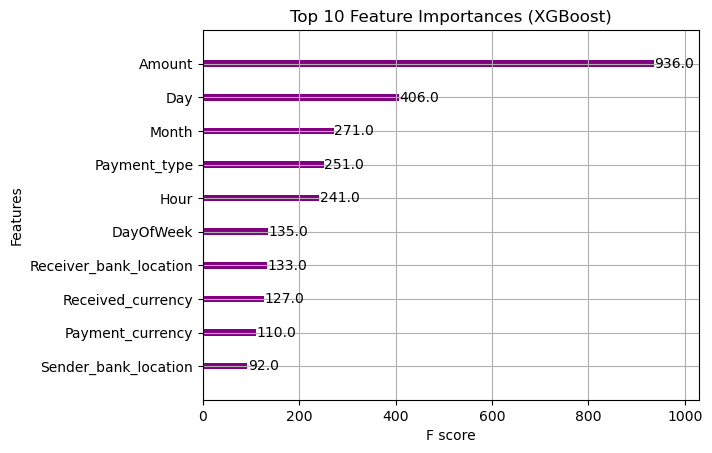

In [50]:
# Plot feature importance using XGBoost built-in method
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10, importance_type='weight', color='purple')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()


## <h2 style="color:#00ced1"> Conclusion</h3>
- Transaction Amount** is by far the most influential feature
- Followed by Day, Month**, and Payment Type,
- Time-based features like Hour, Day of Week, and Part of Month also played a noticeable role.

This kind of interpretability helps in understanding how the model makes decisions and can also guide future feature engineering or domain-specific investigations.

# <h1 style="color:#ff69b4">10-Explainablity</h1>


## <h2 style="color:#00ced1"> SHAP</h3>


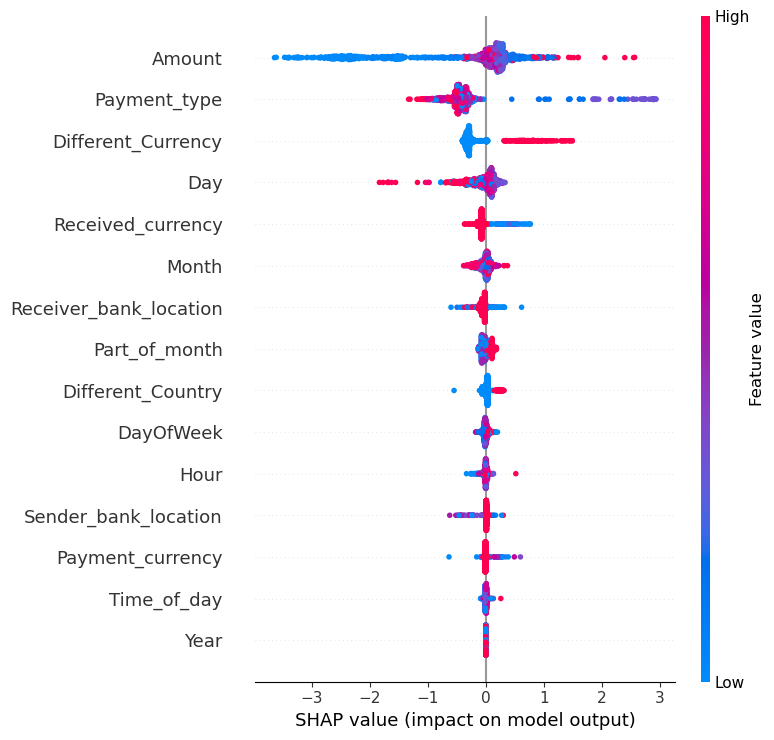

In [51]:
# TreeExplainer for SHAP values
explainer = shap.TreeExplainer(xgb_model)

# Sample a few rows from X_test to reduce computation
X_test_sample = X_test.sample(n=1000, random_state=42)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

# Summary plot to visualize top features
shap.summary_plot(shap_values, X_test_sample)


## <h2 style="color:#00ced1"> Conclusion</h3>
### To get a better idea of what’s really driving our model’s decisions, we used something called SHAP. You can think of SHAP as a way to peek inside the model’s brain and see which features it's paying attention to when making predictions.
In the plot above:
- Each dot represents a transaction from the dataset.
- The position on the x-axis shows how much that feature pushed the prediction toward either “money laundering” or “not laundering.”
- The color shows the value of the feature — red means a high value, blue means a low one.
### What we learned!!!!!:
- The Amount of the transaction clearly plays a major role — higher amounts (red dots on the right) are more likely to be flagged as suspicious.
- Payment type, currency differences, and even the day of the transaction also have strong influence.
- Interestingly, our new features like Different_Currency and Different_Country turned out to be quite helpful — the model is actually using them to make better decisions.
### This kind of interpretation is super important, especially in sensitive areas like anti-money laundering. It helps us build models that aren’t just accurate but also explainable and trustworthy.

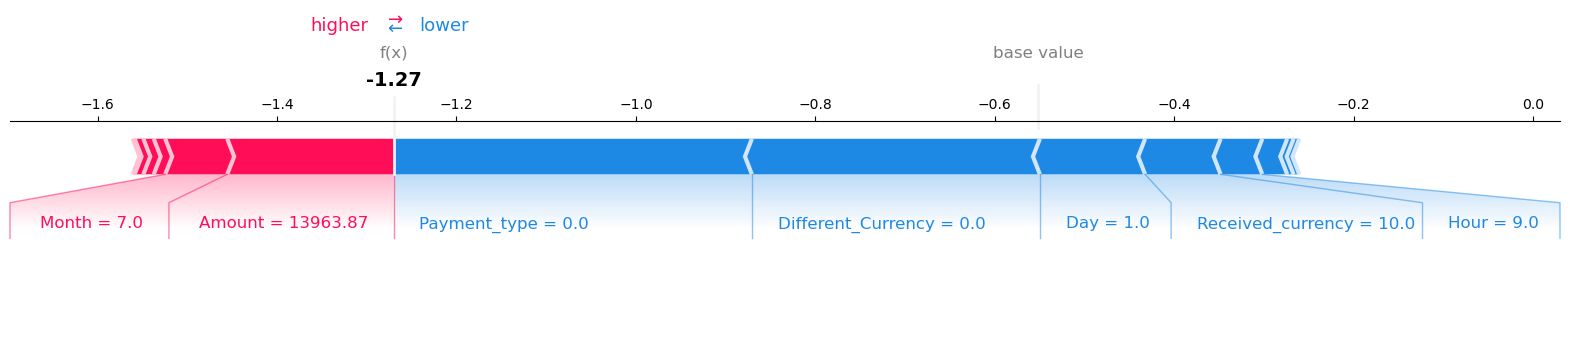

In [52]:
# Create a SHAP explainer using TreeExplainer 
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

# Pick one random sample to explain
sample_index = 0
sample = X_val.iloc[sample_index]

# FORCE PLOT for a single prediction
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_index],
    sample,
    matplotlib=True
)

## SHAP Force Plot --> Individual Prediction Explanation

### The SHAP force plot visualizes how the model made its decision for one specific transaction. Each feature either increased or decreased the model’s confidence that this transaction was suspicious.

### In this case, even though the amount was high and it occurred in July (features associated with suspicious behavior), other features like the payment type and matching currencies helped pull the prediction back toward normal. This kind of explanation builds trust in the model by showing that it's not just reacting to one variable but considering multiple factors together.


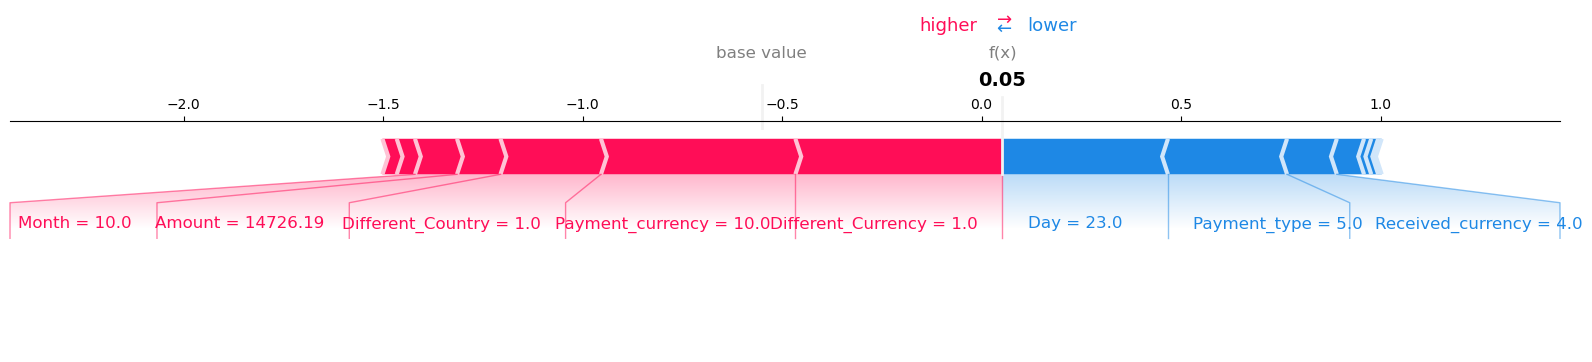

In [53]:
# Find an index of a suspicious transaction from validation set
suspicious_index = y_val[y_val == 1].index[0]

# Extract the sample
suspicious_sample = X_val.loc[suspicious_index]

# Create SHAP explainer for suspicious transaction
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

# Plot the force plot for the suspicious transaction
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[suspicious_index],
    suspicious_sample,
    matplotlib=True
)

## <h2 style="color:#00ced1"> Conclusion</h3>
## These features pushed the model toward predicting this as suspicious:
- Month = 10 (October): Some months may have higher laundering activity historically, so this raised a red flag.
- Amount = 14,726.19: High transaction amounts often indicate abnormal behavior.
- Different_Country = 1: The sender and receiver are in different countries, which is a key laundering risk.
- Different_Currency = 1: A currency exchange is involved — another common laundering pattern.
- Payment_currency = 10.0: Possibly an unusual or less commonly used currency.
## These features are shown in red, meaning they added weight to the suspicion.

===========================
## These features pulled the prediction back toward normal:
- Day = 23.0: This could be a typical time in the month for legitimate transactions (e.g., salary dates).
- Payment_type = 5.0: A type that’s usually not linked to laundering.
- Received_currency = 4.0: Might be a stable, familiar currency that doesn’t raise alarms.

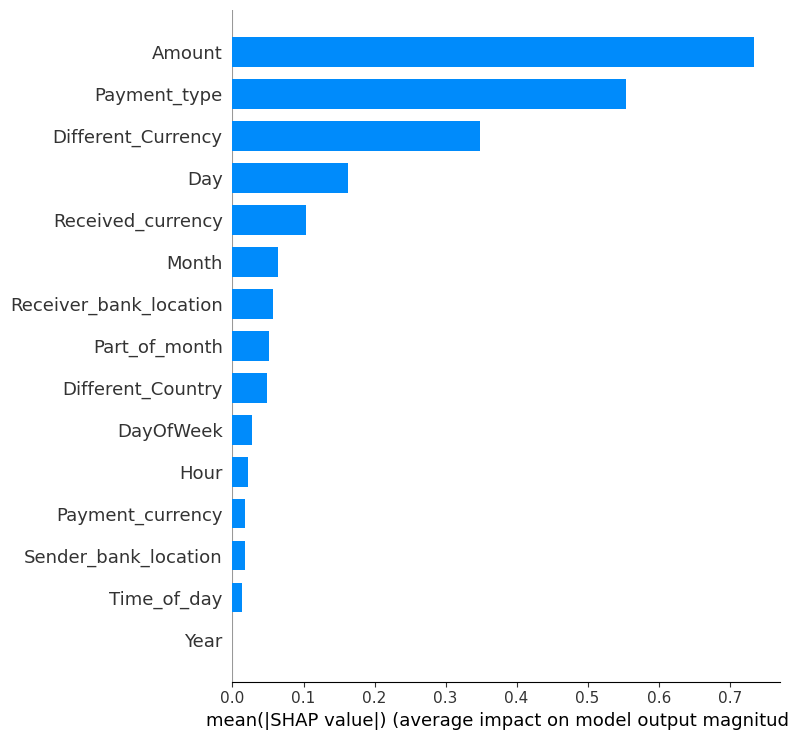

In [54]:
# SHAP Summary bar plot
shap.summary_plot(shap_values, X_val, plot_type="bar")

### SHAP Summary Bar Plot

### The SHAP summary bar plot provides a clear view of which features had the most overall influence on the XGBoost model's predictions across the validation dataset. Each bar represents a feature, and its length indicates the average impact (positive or negative) that feature had on the prediction outcome.

- **Amount** was the most influential factor in detecting potential laundering activity. High or unusual amounts heavily contributed to classification decisions.
- **Payment_type** and **Different_Currency** followed as key indicators. These features suggest that the type of transaction and whether currency conversion occurred are critical clues in detecting suspicious activity.
- Features like **Day**, **Received_currency**, and **Month** had moderate impact.
- Some features, such as **Time_of_day**, **Sender_bank_location**, and **Year**, had relatively low importance and minimal influence on the model’s decision-making.

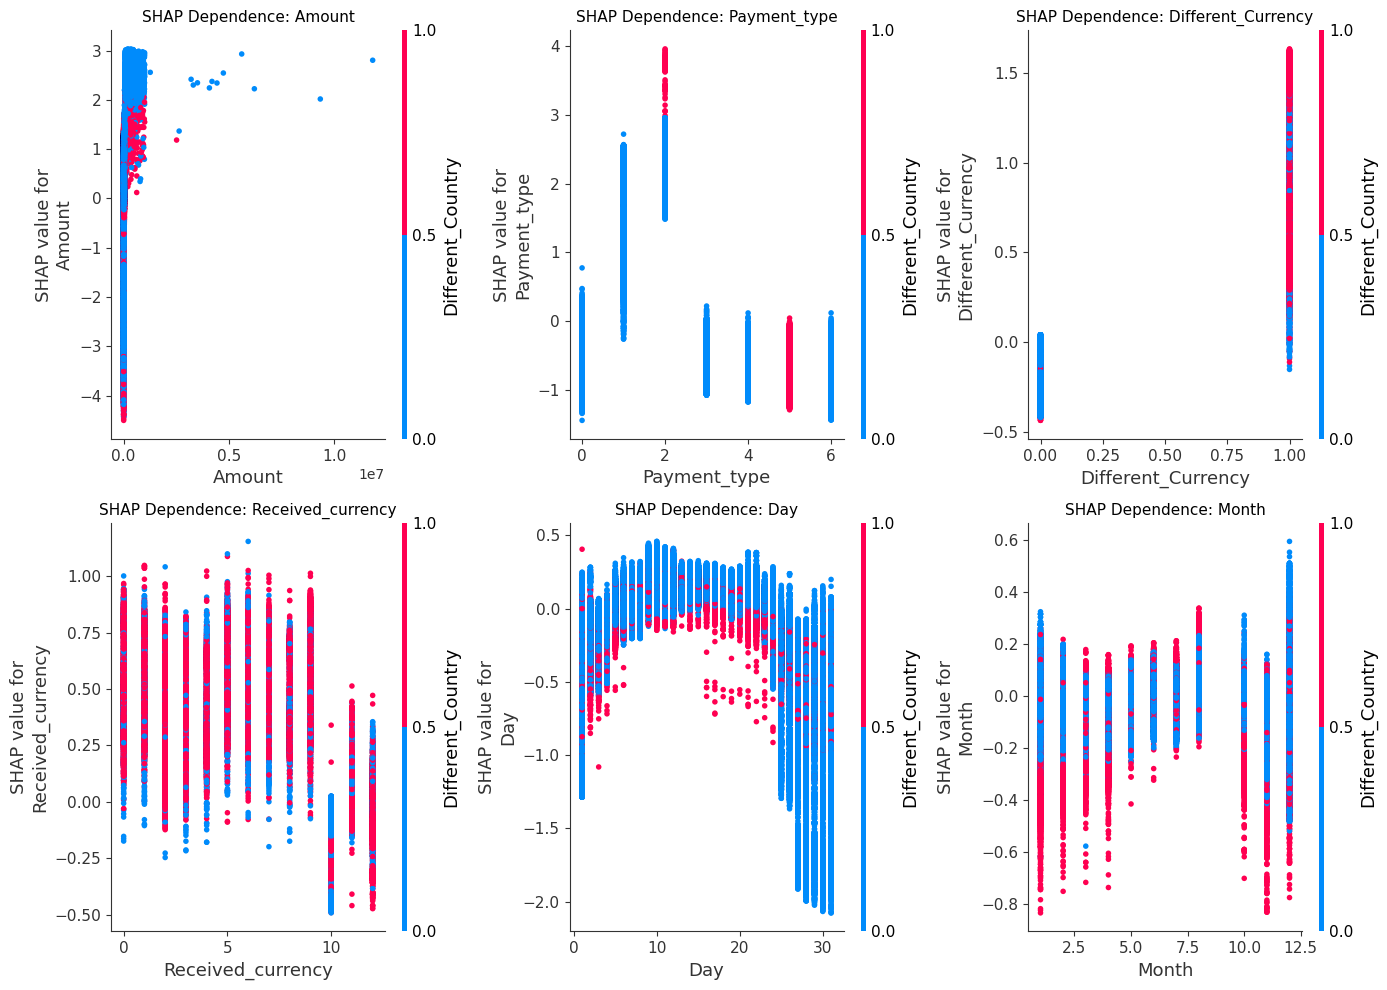

In [55]:
shap.initjs()

# Define the features to plot and the interaction feature --> We choose different_country as our interaction_feature
features_to_plot = [ "Amount", 
    "Payment_type", 
    "Different_Currency", 
    "Received_currency", 
    "Day", 
    "Month"]
interaction_feature = "Different_Country"

# Create subplots for each feature
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Loop through each feature and generate SHAP dependence plot
for i, feature in enumerate(features_to_plot):
    shap.dependence_plot(
        feature,
        shap_values,
        X_val,
        interaction_index=interaction_feature,
        ax=axs[i],
        show=False
    )

# Add a title for each subplot
for ax, feature in zip(axs, features_to_plot):
    ax.set_title(f"SHAP Dependence: {feature}", fontsize=11)

plt.tight_layout()
plt.show()


## SHAP Dependence Plot Insights ----> Feature Interactions with Different_Country
### These SHAP dependence plots help us understand how the most important features influence the XGBoost model’s predictions, especially in relation to whether the transaction occurred across different countries (Different_Country).
- Amount: Higher transaction amounts tend to push the model toward predicting suspicious behavior (higher SHAP values), particularly when the transaction crosses country borders (pink/red dots).
- Payment_type: Some payment types (e.g., ACH, wire transfers) are associated with increased model suspicion. Foreign transactions (in red) amplify this effect at specific payment types.
- Different_Currency: When a transaction involves currency exchange (value = 1), the model's SHAP value rises, especially for international transactions — highlighting its risk.
- Received_currency: The impact of the received currency varies, but some codes (e.g., 5, 6, 10) show a stronger influence when combined with cross-border activity.
- Day: Middle-of-the-month transactions (around days 10–20) tend to have more impact. The pattern shifts slightly depending on whether it's a domestic or foreign transaction.
- Month: Some months (like 7 and 10) show stronger SHAP values. Again, foreign transactions appear to raise suspicion in certain periods.

=======================================================================================================================================================================================================================================================================================

## <h2 style="color:#00ced1"> Conclusion</h3>

## In this project, we developed a machine learning pipeline to identify potentially suspicious (money laundering) transactions using a large, highly imbalanced real-world dataset. We explored and compared the performance of three models — Logistic Regression, Random Forest, and XGBoost. While Logistic Regression provided a useful baseline and Random Forest struggled with recall, XGBoost proved to be the most effective model, especially in capturing rare fraud cases through superior recall and AUC-ROC metrics.
## To enhance transparency and support regulatory compliance, we used SHAP to interpret model predictions. This analysis revealed that features such as Amount, Payment_type, and Different_Currency played a significant role in influencing model decisions. These insights not only strengthened trust in the model's outcomes but also offered practical explanations that align with known AML patterns.
## Overall, the resulting XGBoost model demonstrated strong detection capability and interpretability, making it a valuable tool for financial institutions aiming to proactively mitigate AML risks.
